In [187]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [188]:
df = pd.read_csv("../files/BRISTOR_Zegoland_all_%.csv")

df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)

In [189]:
X=df.iloc[:,8:13]
y=df.iloc[:,4:5]

data=pd.concat([y,X],axis=1)

data.head()

,Value,DemandShareA,newPatientShareA,newPatientShareB,totalPatientShareA,totalPatientShareB
Date,,,,,,
2021-11-01,56305.84,0.013829,0.05,0.001,0.01,0.000
2021-12-01,35581.00,0.013842,0.06,0.021,0.01,0.001
2022-01-01,41136.88,0.013942,0.05,0.026,0.01,0.002
2022-02-01,41689.80,0.014830,0.04,0.041,0.02,0.004
2022-03-01,54587.28,0.016513,0.05,0.028,0.02,0.005


In [190]:
# List of columns to create lags for
columns_to_lag = ['Value', 'DemandShareA']


In [191]:
# Create lagged features
def create_lagged_features(data, lags):
    lagged_data = pd.DataFrame()
    for lag in range(1, lags + 1):
        lagged_data[f'X_lag{lag}'] = data['DemandShareA'].shift(lag)
        lagged_data[f'y_lag{lag}'] = data['Value'].shift(lag)
    lagged_data['y'] = data['Value']  # Target variable
    lagged_data.dropna(inplace=True)  # Drop rows with NaN values
    return lagged_data

lagged_data = create_lagged_features(data, lags=2)
lagged_data.head()

,X_lag1,y_lag1,X_lag2,y_lag2,y
Date,,,,,
2022-01-01,0.013842,35581.00,0.013829,56305.84,41136.88
2022-02-01,0.013942,41136.88,0.013842,35581.00,41689.80
2022-03-01,0.014830,41689.80,0.013942,41136.88,54587.28
2022-04-01,0.016513,54587.28,0.014830,41689.80,40157.08
2022-05-01,0.017154,40157.08,0.016513,54587.28,60124.30


In [192]:
data.head()

,Value,DemandShareA,newPatientShareA,newPatientShareB,totalPatientShareA,totalPatientShareB
Date,,,,,,
2021-11-01,56305.84,0.013829,0.05,0.001,0.01,0.000
2021-12-01,35581.00,0.013842,0.06,0.021,0.01,0.001
2022-01-01,41136.88,0.013942,0.05,0.026,0.01,0.002
2022-02-01,41689.80,0.014830,0.04,0.041,0.02,0.004
2022-03-01,54587.28,0.016513,0.05,0.028,0.02,0.005


In [193]:
features = lagged_data[['X_lag1', 'y_lag1', 'X_lag2', 'y_lag2']]
target = lagged_data['y']

In [194]:
from sklearn.preprocessing import MinMaxScaler
# Normalize the features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [195]:
# Determine the split index
split_index = int(len(features_scaled) * 0.8)

# Split the data while preserving time order
X_train, X_test = features_scaled[:split_index], features_scaled[split_index:]
y_train, y_test = target[:split_index], target[split_index:]

In [196]:
n_features = 2
n_steps=2

# Define LSTM model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(n_steps, n_features)),
    
    Dense(1)  # Predict single future y
])
model.compile(optimizer='adam', loss='mse')

/Users/anastasiaganshof/anaconda3/envs/Bio-210/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [197]:
print(X_train.shape)

(23, 4)


In [198]:
X_train

array([[0.        , 0.        , 0.        , 0.28119032],
       [0.00760518, 0.07538102, 0.0009659 , 0.        ],
       [0.07487303, 0.08288293, 0.00856373, 0.07538102],
       [0.2024422 , 0.25787325, 0.07576661, 0.08288293],
       [0.25101664, 0.0620873 , 0.20321256, 0.25787325],
       [0.2933755 , 0.33299839, 0.25174008, 0.0620873 ],
       [0.37275947, 0.12001173, 0.29405803, 0.33299839],
       [0.39139833, 0.38680988, 0.37336533, 0.12001173],
       [0.50134174, 0.27803228, 0.39198618, 0.38680988],
       [0.38237591, 0.22460774, 0.5018234 , 0.27803228],
       [0.45349347, 0.29915245, 0.38297248, 0.22460774],
       [0.48310142, 0.37113827, 0.45402134, 0.29915245],
       [0.58932107, 0.37141288, 0.48360069, 0.37113827],
       [0.63330491, 0.4712531 , 0.58971775, 0.37141288],
       [0.55442433, 0.43807497, 0.6336591 , 0.4712531 ],
       [0.66483463, 0.52655624, 0.55485471, 0.43807497],
       [0.61278005, 0.32156454, 0.66515837, 0.52655624],
       [0.73369398, 0.25469025,

In [199]:
X_train.shape

(23, 4)

In [200]:
X_train = X_train.reshape((X_train.shape[0], 2, 2))

X_train

array([[[0.        , 0.        ],
        [0.        , 0.28119032]],

       [[0.00760518, 0.07538102],
        [0.0009659 , 0.        ]],

       [[0.07487303, 0.08288293],
        [0.00856373, 0.07538102]],

       [[0.2024422 , 0.25787325],
        [0.07576661, 0.08288293]],

       [[0.25101664, 0.0620873 ],
        [0.20321256, 0.25787325]],

       [[0.2933755 , 0.33299839],
        [0.25174008, 0.0620873 ]],

       [[0.37275947, 0.12001173],
        [0.29405803, 0.33299839]],

       [[0.39139833, 0.38680988],
        [0.37336533, 0.12001173]],

       [[0.50134174, 0.27803228],
        [0.39198618, 0.38680988]],

       [[0.38237591, 0.22460774],
        [0.5018234 , 0.27803228]],

       [[0.45349347, 0.29915245],
        [0.38297248, 0.22460774]],

       [[0.48310142, 0.37113827],
        [0.45402134, 0.29915245]],

       [[0.58932107, 0.37141288],
        [0.48360069, 0.37113827]],

       [[0.63330491, 0.4712531 ],
        [0.58971775, 0.37141288]],

       [[0.55442433,

In [201]:
X_train.shape

(23, 2, 2)

In [202]:
y_train.shape

(23,)

In [203]:
X_train.shape

(23, 2, 2)

In [204]:
# Train the model
history=model.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.2)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 3806995968.0000 - val_loss: 7726435328.0000
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3418717440.0000 - val_loss: 7726431232.0000
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3609340928.0000 - val_loss: 7726429184.0000
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3532152320.0000 - val_loss: 7726425600.0000
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3567198464.0000 - val_loss: 7726422528.0000
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3626211584.0000 - val_loss: 7726418944.0000
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 3527466752.0000 - val_loss: 7726415872.0000
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3726951168.0000 - val_loss: 7726412800.0000
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3757391360.0000 - val_loss: 7726409216.0000
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3833138944.0000 - val_loss: 7726

In [205]:
X_test = X_test.reshape((X_test.shape[0], 2, 2))

In [206]:
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Test RMSE: 96429.781


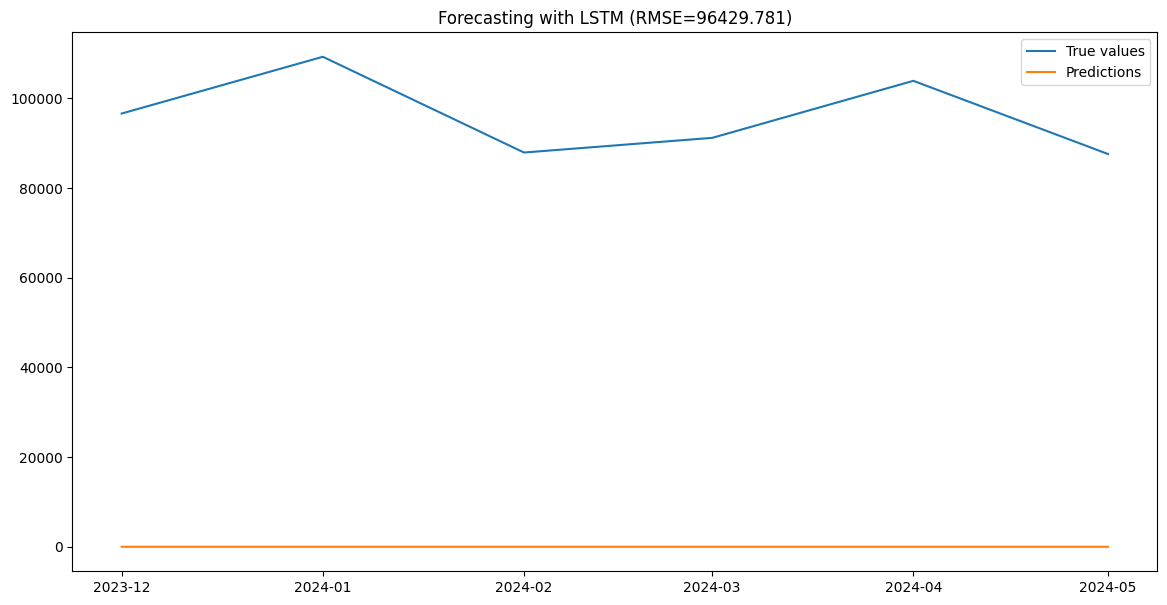

In [207]:
#rmse
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='True values')
plt.plot(y_test.index, y_pred, label='Predictions')
plt.title(f'Forecasting with LSTM (RMSE={rmse:.3f})')
plt.legend()
plt.show()


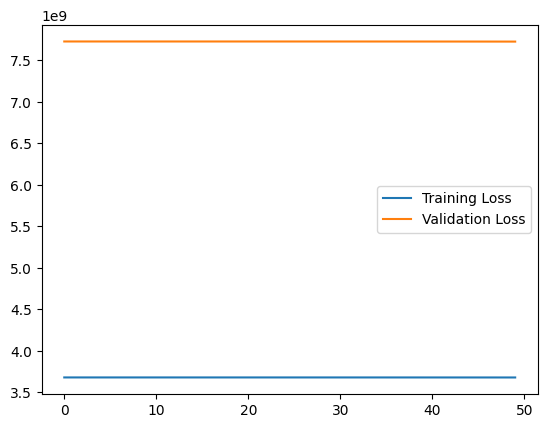

In [208]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()